# En este Notebook realizaremos detección, censura y remoción de atípicos utilizando los métodos de RIQ, media-desviación estándar, cuantiles y LOF.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
from sklearn.neighbors import LocalOutlierFactor

import sys
sys.path.append('/home/ia/cursoECI/cursoIV/src')
import diagnostic_functions

In [3]:
# Cargando datos Boston House
boston_dataset = pd.read_csv('/home/ia/cursoECI/cursoIV/Datasets/raw/boston.csv')

In [4]:
# Creamos un dataframe con variables independientes. Usaremos solo 3 variables para propósitos de demostración
#boston = boston_dataset.filter(['RM', 'LSTAT', 'CRIM'], axis=1)
boston = boston_dataset[['RM', 'LSTAT', 'CRIM']].copy()

boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


### Visualización

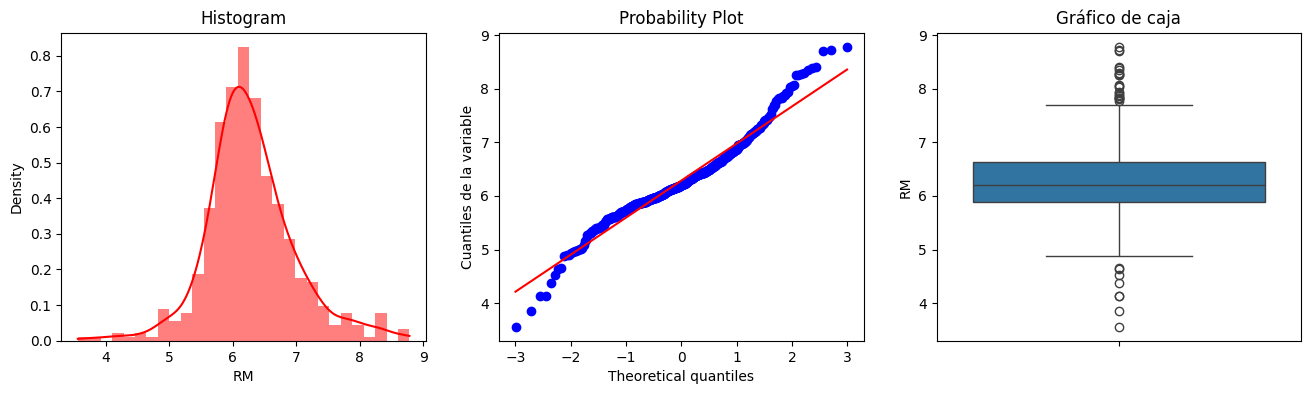

In [5]:
# Visualizamos con la función de diagnóstico los valores extremos en RM
diagnostic_functions.diagnostic_plots2(boston, 'RM')


In [6]:


def find_boundaries_RIQ(df, variable, distance):

    # Calculamos las froteras (distribución sesgada)
    # La distancia es pasada como argunmento

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary



def find_boundaries_zscore(df, variable, distance):
    lower_boundary = df[variable].mean() - (df[variable].std() * distance)
    upper_boundary = df[variable].mean() + (df[variable].std() * distance)
    return upper_boundary, lower_boundary

def find_boundaries_quantile(df, variable):
    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)
    return upper_boundary, lower_boundary

In [7]:
# Encontremos los límites RM usando la regla RIQ
RM_upper_limit, RM_lower_limit = find_boundaries_RIQ(boston, 'RM',1.5)
RM_upper_limit, RM_lower_limit

(7.730500000000001, 4.778499999999999)

### Censura de valores atípicos

In [8]:
# Censuremos los outliers por los limites máximo y mínimo

boston['RM_censured']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

boston.head(10)

,RM,LSTAT,CRIM,RM_censured
0,6.575,4.98,0.00632,6.575
1,6.421,9.14,0.02731,6.421
2,7.185,4.03,0.02729,7.185
3,6.998,2.94,0.03237,6.998
4,7.147,5.33,0.06905,7.147
5,6.430,5.21,0.02985,6.430
6,6.012,12.43,0.08829,6.012
7,6.172,19.15,0.14455,6.172
8,5.631,29.93,0.21124,5.631
9,6.004,17.10,0.17004,6.004


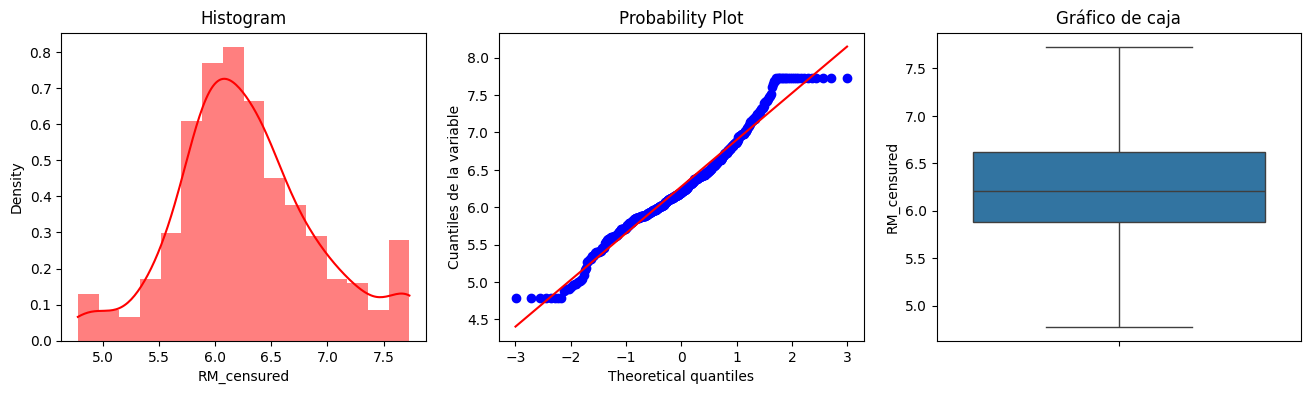

In [9]:
diagnostic_functions.diagnostic_plots2(boston,'RM_censured')

### Remoción de valores atípicos

In [10]:
# Marquemos los outliers en el cto. de datos

outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))
outliers_RM

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [11]:
# Removemos del conjunto de datos solo los outliers en RM

boston_trimmed = boston.loc[~outliers_RM ]
boston.shape, boston_trimmed.shape

((506, 4), (476, 4))

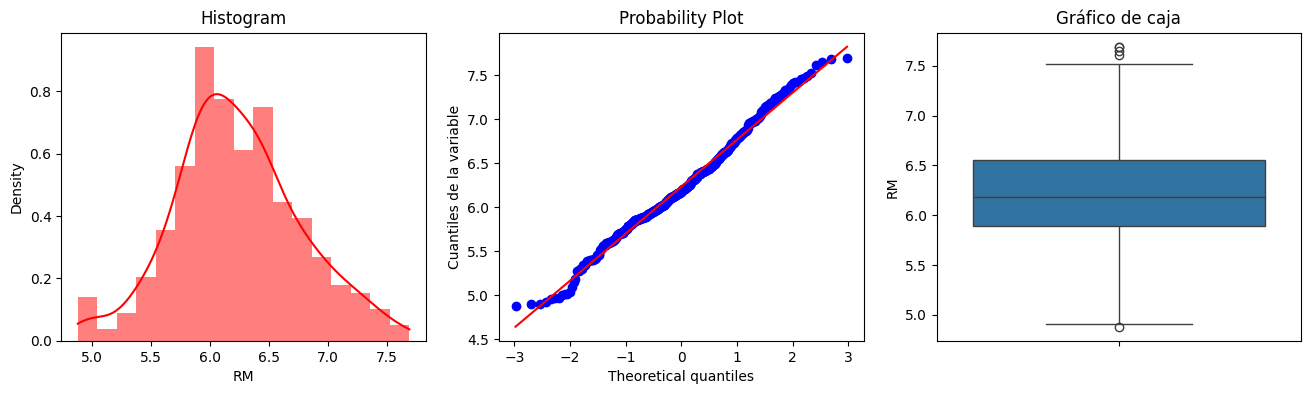

In [12]:
# Exploremos los valores extremos en los datos removidos
# para la variable RM vemos muchos menos outliers 
# que en los datos originales
diagnostic_functions.diagnostic_plots2(boston_trimmed, 'RM')

### Detección y remociuón de atípicos utilizando LOF

In [13]:
np.random.seed(42)

# Generamos los datos sintéticos (inliers) de entrenamiento para propositos de demostración
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

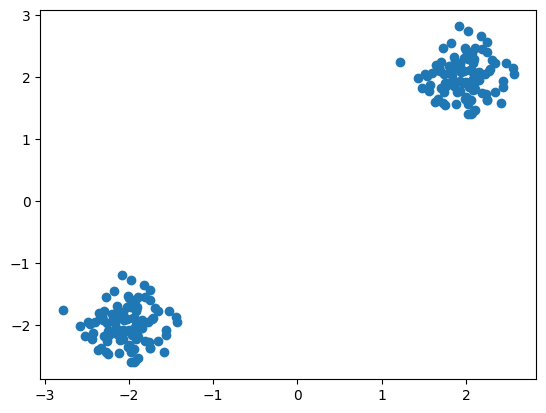

In [14]:
# Graficamos los inliers
X_inliers.shape
plt.scatter(X_inliers[:,0],X_inliers[:,1])
plt.show()

In [15]:
# Generemos algunos outliers (20)
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

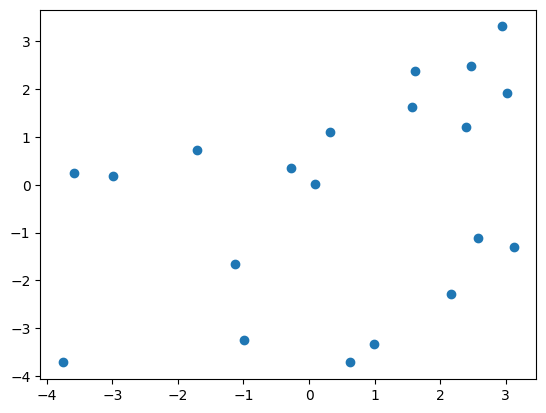

In [16]:
# Graficamos los outliers generados
X_outliers.shape
plt.scatter(X_outliers[:,0],X_outliers[:,1])
plt.show()

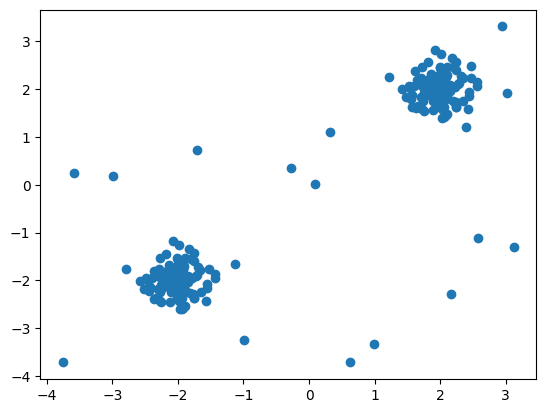

In [17]:
#Ambos, inliers y outliers
X.shape
plt.scatter(X[:,0],X[:,1])
plt.show()

In [18]:
# Creamos un narray indicando si es la observación es atípica (-1) o no (1)
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [19]:
# Instanciamos y entrenamos LOF (default) y obtenemos y_pred = 1:inlier -1:outlier
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)

In [20]:
# Cuantificamos los errores
n_errors = (y_pred != ground_truth).sum()
print(n_errors)

8


In [21]:
# Obtenemos los scores
X_scores = clf.negative_outlier_factor_
X_scores

array([-0.99994411, -1.14405944, -0.97422441, -1.29043229, -0.96406015,
       -0.967451  , -1.16897405, -1.17786476, -1.01083896, -1.14511932,
       -1.21255557, -1.05066867, -0.96961357, -1.02846721, -0.96108146,
       -1.30563699, -1.01782283, -1.09341031, -1.20053   , -1.048392  ,
       -1.04273309, -0.96537973, -1.12978593, -1.04714221, -1.1241528 ,
       -0.97795087, -0.97358493, -1.13261793, -0.98280096, -1.02069094,
       -0.95891097, -1.1491003 , -1.11886905, -0.99855726, -0.99357848,
       -1.13283666, -1.1460512 , -1.87981613, -0.95747372, -1.2240096 ,
       -0.9432555 , -1.25135605, -1.00309851, -1.10715506, -0.97725017,
       -0.99886729, -0.97739557, -1.09329811, -0.99310409, -0.96318902,
       -1.08969429, -0.97382438, -0.94892287, -1.42556212, -0.96379941,
       -1.27724298, -1.46492263, -0.94595752, -1.04083691, -1.1733885 ,
       -1.06562769, -1.29284358, -1.32423841, -1.06358314, -0.96642636,
       -1.08777278, -1.03217634, -1.24655122, -0.97201908, -1.09

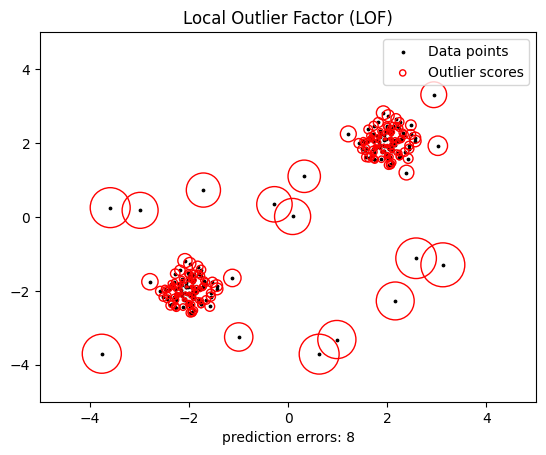

In [22]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# Graficamos circulos con radio proporcional a los outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

### Detección de atípicos basada en algoritmos de clustering

Se deja como ejercicio